# Time Series Analysis Project
based on Kaggle: <https://www.kaggle.com/c/web-traffic-time-series-forecasting/data>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime
from datetime import date
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Cleansing


*   missing values
*   `Page`: seperate Page names to each attribute
 - Accoriding to description of data: The page names contain the Wikipedia project (e.g. en.wikipedia.org), type of access (e.g. desktop) and type of agent (e.g. spider). In other words, each article name has the following format: 'name_project_access_agent' (e.g. 'AKB48_zh.wikipedia.org_all-access_spider')



In [ ]:
# load data
train = pd.read_csv('/content/drive/My Drive/Kaggle/web_traffic/train_1.csv', header = 0)
#key = pd.read_csv('/content/drive/My Drive/Kaggle/web_traffic/key_1.csv', header = 0)
#sub = pd.read_csv('/content/drive/My Drive/Kaggle/web_traffic/sample_submission_1.csv', header = 0)

In [ ]:
print(train.head(3))
print(train.shape)

                                      Page  2015-07-01  ...  2016-12-30  2016-12-31
0  2NE1_zh.wikipedia.org_all-access_spider        18.0  ...        18.0        20.0
1   2PM_zh.wikipedia.org_all-access_spider        11.0  ...        26.0        20.0
2    3C_zh.wikipedia.org_all-access_spider         1.0  ...         4.0        17.0

[3 rows x 551 columns]
(145063, 551)


In [ ]:
train = train.drop(train.columns[1:185], axis = 1)
train.head(1)

,Page,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,9.0,16.0,6.0,19.0,20.0,19.0,22.0,30.0,14.0,16.0,22.0,15.0,15.0,26.0,16.0,13.0,27.0,18.0,13.0,32.0,31.0,16.0,38.0,18.0,9.0,14.0,10.0,24.0,8.0,15.0,18.0,10.0,23.0,17.0,11.0,26.0,14.0,8.0,12.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0


In [ ]:
train = pd.melt(train, id_vars = 'Page', value_vars = train.columns[1:]).rename(columns = {'variable':'Date', 'value':'Visits'}).sort_values(by = ['Page', 'Date'])
train

,Page,Date,Visits
37206,!vote_en.wikipedia.org_all-access_all-agents,2016-01-01,3.0
182269,!vote_en.wikipedia.org_all-access_all-agents,2016-01-02,2.0
327332,!vote_en.wikipedia.org_all-access_all-agents,2016-01-03,2.0
472395,!vote_en.wikipedia.org_all-access_all-agents,2016-01-04,2.0
617458,!vote_en.wikipedia.org_all-access_all-agents,2016-01-05,3.0
...,...,...,...
52425890,［Alexandros］_ja.wikipedia.org_mobile-web_all-a...,2016-12-27,2336.0
52570953,［Alexandros］_ja.wikipedia.org_mobile-web_all-a...,2016-12-28,2455.0
52716016,［Alexandros］_ja.wikipedia.org_mobile-web_all-a...,2016-12-29,3302.0
52861079,［Alexandros］_ja.wikipedia.org_mobile-web_all-a...,2016-12-30,2789.0


In [ ]:
# english wikipeida 추출
train_en = train[train['Page'].str.contains('en.wikipedia.org', regex = False)]
train_en.head()

,Page,Date,Visits
37206,!vote_en.wikipedia.org_all-access_all-agents,2016-01-01,3.0
182269,!vote_en.wikipedia.org_all-access_all-agents,2016-01-02,2.0
327332,!vote_en.wikipedia.org_all-access_all-agents,2016-01-03,2.0
472395,!vote_en.wikipedia.org_all-access_all-agents,2016-01-04,2.0
617458,!vote_en.wikipedia.org_all-access_all-agents,2016-01-05,3.0


In [ ]:
train_en.shape

(8823528, 3)

### (1) Missing Values
A missing value may mean the traffic was zero or that the data is not available for that day.

In [ ]:
# missing value: 5%
train_en.isna().sum()/len(train_en)

Page      0.000000
Date      0.000000
Visits    0.053417
dtype: float64

In [ ]:
train_en = train_en.fillna(0)
train_en.isna().sum()

Page      0
Date      0
Visits    0
dtype: int64

In [ ]:
corr = pd.pivot_table(train_en, index = 'Month', columns = 'Name', values = 'Visits').corr()

In [ ]:
# 2016년 전 기간동안 값이 0인 데이터 제거
drop_names = corr[corr['!vote'].isna()==True].index.tolist()

for name in drop_names:
  train_en = train_en[train_en['Name'] != name]

### (2) Split `Page`

In [ ]:
names = []; access = []; agents = []
for value in train_en['Page'].values:
  split_list = value.split('_')
  names.append(split_list[0]); access.append(split_list[-2]); agents.append(split_list[-1])

train_en['Name'] = names
train_en['Access'] = access
train_en['Agent'] = agents

In [ ]:
print('Name unqiue: ', train_en['Name'].nunique())
print('Access unqiue: ', train_en['Access'].nunique())
print('Agent unqiue: ', train_en['Agent'].nunique())

Name unqiue:  6631
Access unqiue:  3
Agent unqiue:  2


### (3) Change `Date` format

In [ ]:
train_en['Date'] = pd.to_datetime(train_en['Date'], format = '%Y-%m-%d')

# add additional time variables
train_en['Month'] = train_en['Date'].dt.month
train_en['Day'] = train_en['Date'].dt.day
train_en['Weekday'] = train_en['Date'].dt.weekday
train_en.head()

,Page,Date,Visits,Name,Access,Agent,Month,Day,Weekday
37206,!vote_en.wikipedia.org_all-access_all-agents,2016-01-01,3.0,!vote,all-access,all-agents,1,1,4
182269,!vote_en.wikipedia.org_all-access_all-agents,2016-01-02,2.0,!vote,all-access,all-agents,1,2,5
327332,!vote_en.wikipedia.org_all-access_all-agents,2016-01-03,2.0,!vote,all-access,all-agents,1,3,6
472395,!vote_en.wikipedia.org_all-access_all-agents,2016-01-04,2.0,!vote,all-access,all-agents,1,4,0
617458,!vote_en.wikipedia.org_all-access_all-agents,2016-01-05,3.0,!vote,all-access,all-agents,1,5,1


In [ ]:
train_en['Name'].nunique()

6631

## 2. Exploratory Data Analysis


*   Time(overall trend, month, day, weekday)

*   Access/Agent


### (1) Access/Agent based analysis

In [ ]:
def plot_distribution(data,col):
  new_data = data[col].value_counts().sort_index()
  sns.set_style('whitegrid')
  sns.barplot(new_data.index, new_data.values, color = 'powderblue', edgecolor = 'darkgrey')
  
  for i in range(data[col].nunique()):
    plt.annotate(f'{new_data[i]}',xy=(i, new_data[i] + 150000), ha = 'center', va = 'center', color = 'black')
  plt.title(f'Distribution of {col}', fontsize = 15); plt.ylim(0,max(new_data)+1000000)
  plt.show()

In [ ]:
def plot_comparison_date(data, col):
  new_date = data.groupby([col,'Date'])['Visits'].mean().reset_index()
  plt.figure(figsize=(10,5))
  colors = ['#656371', '#ff7369', 'powderblue']
  sns.lineplot(data = new_date, x = 'Date', y = 'Visits', hue = col, palette= colors[:data[col].nunique()])
  plt.title(f'Average {col} distribution overall time', fontsize = 15)
  plt.show()

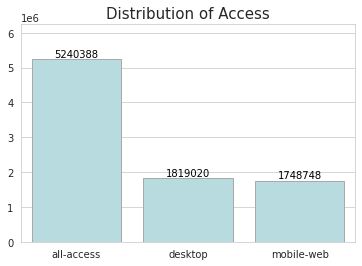

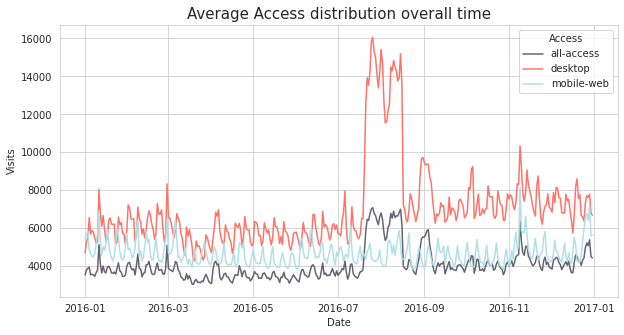

In [ ]:
# Access
plot_distribution(train_en, 'Access')
print('\n')
plot_comparison_date(train_en, 'Access')

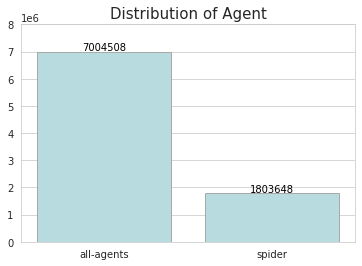

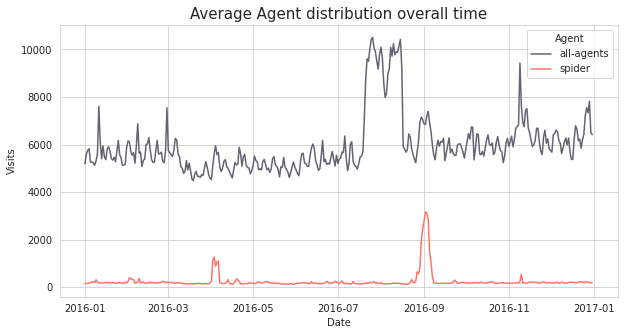

In [ ]:
plot_distribution(train_en, 'Agent')
print('\n')
plot_comparison_date(train_en, 'Agent')

### (2) Time based analysis

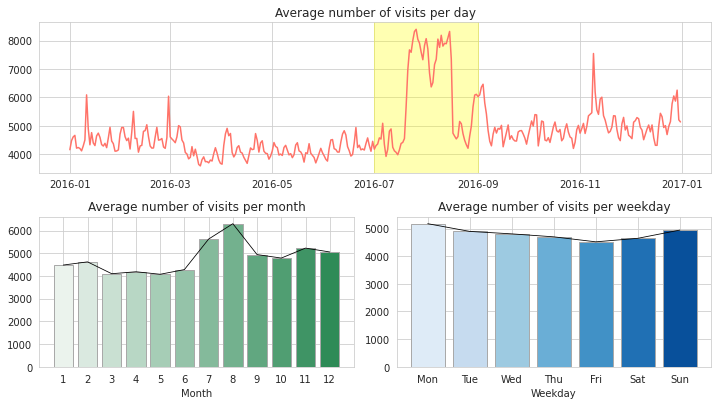

In [ ]:
fig = plt.figure(figsize = (20,8))
ax = [None for _ in range(3)]

ax[0] = plt.subplot2grid((3,4), (0,0), colspan = 2)
ax[1] = plt.subplot2grid((3,4), (1,0), colspan = 1)
ax[2] = plt.subplot2grid((3,4), (1,1), colspan = 1)

date_mean = train_en.groupby(['Date'])['Visits'].mean().reset_index()
ax[0].plot(date_mean['Date'], date_mean['Visits'], color = '#ff7369', linestyle = '-')
ax[0].axvspan(datetime.date(2016,7,1),datetime.date(2016,9,1), color = 'yellow', alpha = 0.3, label = 'skyrocket period')
ax[0].set_title('Average number of visits per day')

month_mean = train_en.groupby(['Month'])['Visits'].mean().reset_index()
weekday_mean = train_en.groupby(['Weekday'])['Visits'].mean().reset_index()
ax[1].bar(month_mean['Month'], month_mean['Visits'], color = sns.light_palette("seagreen", len(month_mean)), edgecolor = 'darkgrey')
ax[1].plot(month_mean['Month'], month_mean['Visits'], color = 'black', linewidth = 0.8)
ax[1].set_xticks(range(1,13)); ax[1].set_xlabel('Month'); ax[1].set_title('Average number of visits per month')

ax[2].bar(weekday_mean['Weekday'], weekday_mean['Visits'], color = sns.color_palette("Blues", len(weekday_mean)), edgecolor = 'darkgrey')
ax[2].plot(weekday_mean['Weekday'], weekday_mean['Visits'], color = 'black', linewidth = 0.8)
ax[2].set_xticklabels(['Mon','Mon','Tue','Wed','Thu','Fri','Sat','Sun']); ax[2].set_xlabel('Weekday'); ax[2].set_title('Average number of visits per weekday')

fig.tight_layout()

### Clustering

In [ ]:
corr = pd.pivot_table(train_en, index = 'Month', columns = 'Name', values = 'Visits').corr()

In [ ]:
import scipy.cluster.hierarchy as spc
def hierarchical_clustering(correlation, method, param): 
    pdist = spc.distance.pdist(correlation)
    linkage = spc.linkage(pdist, method=method)
    idx = spc.fcluster(linkage, param * pdist.max(), 'distance')
    cluster = pd.DataFrame({'Name':correlation.index, 'Cluster':idx})   
    return cluster

In [ ]:
cluster_1 = hierarchical_clustering(corr,'complete',0.7)
print('Number of clusters: ',cluster_1['Cluster'].nunique())

,Name,Cluster
0,!vote,9
1,"""Awaken,",2
2,"""European",8
3,"""Heroes""",11
4,"""Weird",12
...,...,...
6594,Zurich.minds,2
6595,d-block,8
6596,Álvaro,8
6597,Éder,4


In [ ]:
train_cluster = pd.merge(train_en, cluster_1, on='Name')

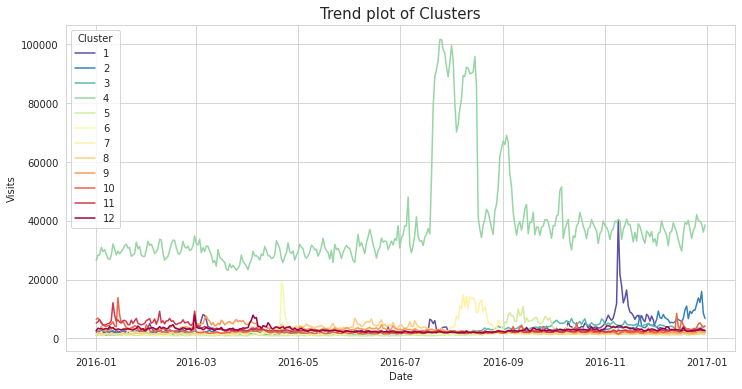

In [ ]:
plt.figure(figsize=(12,6))
c_mean = train_cluster.groupby(['Cluster','Date'])['Visits'].mean().reset_index()
sns.lineplot(data=c_mean, x= 'Date', y='Visits',hue='Cluster', legend = 'full', palette = 'Spectral_r')
plt.title('Trend plot of Clusters', fontsize = 15)
plt.show()